## requirement

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from sklearn import model_selection as sk_model_selection
from sklearn.metrics import roc_auc_score
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from torch.optim import lr_scheduler
from tqdm import tqdm
import re
import cv2
import random
from torch.utils.data import Dataset
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
import monai

In [2]:
#명령프롬포트에서 다음 실행
#!pip install './RSNA_Monai_Packages/monai-0.6.0-202107081903-py3-none-any.whl'

## GPU 세팅

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda")

## 하이퍼파라미터

In [5]:
TITLE = '1_FLAIR'
MODALITY_LUT = False
VOI_LUT = False
EXCLUDE = [109, 123, 709]   
TYPES = ["FLAIR", "T1w", "T2w", "T1wCE"]
IMAGE_TYPE = "FLAIR"
KERNEL_SIZE = (3,3)
TOPPHAT = False
MORPHOLOGY = False

num_folds=5
Selected_fold=1 #1,2,3,4,5 

NUM_IMAGES_3D = 64
IMAGE_SIZE = 256
N_EPOCHS = 50
do_valid = True
type_ = "T1wCE"

## Loading Data

In [6]:
train_df = pd.read_csv("../../data/train_df.csv")
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]
train_df['Fold'] = 'train'
test_df = pd.read_csv("../../data/test_df.csv")
test_df['Fold'] = 'test'
train_df.head()

,BraTS21ID,MGMT_value,Fold
0,185,1,train
1,816,1,train
2,707,1,train
3,683,0,train
4,6,1,train


In [7]:
len(train_df), len(test_df)

(466, 117)

In [8]:
from sklearn.model_selection import KFold,StratifiedKFold
sfolder = StratifiedKFold(n_splits=5,random_state=13,shuffle=True)
X = train_df[['BraTS21ID']]
y = train_df[['MGMT_value']]

fold_no = 1
for train, valid in sfolder.split(X,y):
    if fold_no==Selected_fold:
        train_df.loc[valid, "Fold"] = "valid"
    fold_no += 1

In [9]:
df_train=train_df[train_df.Fold=="train"]
df_valid=train_df[train_df.Fold=="valid"]
print("df_train=",len(df_train),"-- df_valid=",len(df_valid))

df_train= 372 -- df_valid= 94


In [10]:
def load_dicom(path,modality_lut=MODALITY_LUT,voi_lut=VOI_LUT,TOPPHAT=TOPPHAT,MORPHOLOGY=MORPHOLOGY,size=IMAGE_SIZE):
    # read dicom
    dicom = pydicom.read_file(path)

    # pixel array
    data = dicom.pixel_array
    
    if modality_lut:
        # 기울기와 절편을 적용해주지 않으면 brightness가 엉망이 될 수도 있다고 한다.
        data = apply_modality_lut(data,dicom)
    
    if voi_lut :
        # window center와 window width에 맞춰 영상의 픽셀값 조정
        data = apply_voi_lut(data,dicom)

    # 16비트 짜리 dicom 이미지를 8비트 (0 ~ 255) 픽셀 데이터로 rescale
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    k = cv2.getStructuringElement(cv2.MORPH_RECT,KERNEL_SIZE)  # tophat or gradient 적용 시 활성화
    if TOPPHAT == True:
        data = cv2.morphologyEx(data, cv2.MORPH_TOPHAT, k)       # tophat 적용
    if MORPHOLOGY == True:
        data = cv2.morphologyEx(data, cv2.MORPH_GRADIENT, k)       # gradient 적용

    # resize
    return cv2.resize(data, (size, size))

- BrainRSNADataset

In [11]:
class BrainRSNADataset(Dataset):
    def __init__(
        self, data, transform=None, mri_type=IMAGE_TYPE, is_train=True
    ):

    #input서 ds_type="forgot",  do_load=True 생략
        self.data = data
        self.type = mri_type

        self.idpath = data["BraTS21ID"].values
        self.target = data["MGMT_value"].values

        self.transform = transform
        self.is_train = is_train
        self.folder = "train" if self.is_train else "test"
        # self.do_load = do_load
        # self.ds_type = ds_type
        # self.img_indexes = self._prepare_biggest_images()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        case_id = int(self.idpath[index])
        target = int(self.target[index])
        _3d_images = self.load_dicom_images_3d(case_id)
        _3d_images = torch.tensor(_3d_images).float()
        if self.is_train:
            return {"image": _3d_images, "target": target, "case_id": case_id}
        else:
            return {"image": _3d_images, "case_id": case_id}

    # def _prepare_biggest_images(self):
    #     big_image_indexes = {}
    #     if (f"big_image_indexes_{self.ds_type}.pkl" in os.listdir("../input/"))\
    #         and (self.do_load) :
    #         print("Loading the best images indexes for all the cases...")
    #         big_image_indexes = joblib.load(f"../input/big_image_indexes_{self.ds_type}.pkl")
    #         return big_image_indexes
    #     else:
            
    #         print("Caulculating the best scans for every case...")
    #         for row in tqdm(self.data.iterrows(), total=len(self.data)):
    #             case_id = str(int(row[1].BraTS21ID)).zfill(5)
    #             path = f"../input/{self.folder}/{case_id}/{self.type}/*.dcm"
    #             files = sorted(
    #                 glob.glob(path),
    #                 key=lambda var: [
    #                     int(x) if x.isdigit() else x for x in re.findall(r"[^0-9]|[0-9]+", var)
    #                 ],
    #             )
    #             resolutions = [utils.extract_cropped_image_size(f) for f in files]
    #             middle = np.array(resolutions).argmax()
    #             big_image_indexes[case_id] = middle

    #         joblib.dump(big_image_indexes, f"../input/big_image_indexes_{self.ds_type}.pkl")
    #         return big_image_indexes



    def load_dicom_images_3d(
        self,
        case_id,
        num_imgs=NUM_IMAGES_3D,
        img_size=IMAGE_SIZE,
        rotate=0,
    ):
        case_id = str(case_id).zfill(5)

        path = f"../../data/train/{case_id}/{self.type}/*.dcm"
        files = sorted(
            glob.glob(path),
            key=lambda var: [
                int(x) if x.isdigit() else x for x in re.findall(r"[^0-9]|[0-9]+", var)
            ],
        )    
        # middle = self.img_indexes[case_id]

        middle = len(files) // 2
        num_imgs2 = num_imgs // 2
        p1 = max(0, middle - num_imgs2)
        p2 = min(len(files), middle + num_imgs2)
        image_stack = [load_dicom(f) for f in files[p1:p2]]
        
        img3d = np.stack(image_stack).T
        if img3d.shape[-1] < num_imgs:
            n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
            img3d = np.concatenate((img3d, n_zero), axis=-1)

        return np.expand_dims(img3d, 0)

In [12]:
train_dataset = BrainRSNADataset(data=df_train,is_train=True)
valid_dataset = BrainRSNADataset(data=df_valid,is_train=True)

In [13]:
train_dl = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
)

validation_dl = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

In [14]:
# model 
# num_classes : output의 갯수 (classification)
# spatial_dims : 입력 이미지의 공간 차원 수
# n_input_channels: 첫 번째 컨볼루션 레이어의 입력 채널 수

model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, n_classes=1)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.5, last_epoch=-1, verbose=True)

model.zero_grad()
model.to(device)
best_loss = 9999
best_auc = 0
criterion = nn.BCEWithLogitsLoss()

Adjusting learning rate of group 0 to 1.0000e-04.


## Train

In [15]:
# 캐시 지우기
# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()

In [16]:
%%time
for counter in range(1,N_EPOCHS+1):

    epoch_iterator_train = tqdm(train_dl)
    tr_loss = 0.0
    for step, batch in enumerate(epoch_iterator_train):
        model.train()
        images, targets = batch["image"].to(device), batch["target"].to(device)

        outputs = model(images)
        targets = targets  # .view(-1, 1)
        loss = criterion(outputs.squeeze(1), targets.float())

        loss.backward()
        optimizer.step()
        model.zero_grad()
        optimizer.zero_grad()

        tr_loss += loss.item()
        epoch_iterator_train.set_postfix(
            batch_loss=(loss.item()), loss=(tr_loss / (step + 1))
        )
    scheduler.step()  # Update learning rate schedule

    if do_valid:
        with torch.no_grad():
            val_loss = 0.0
            preds = []
            true_labels = []
            case_ids = []
            epoch_iterator_val = tqdm(validation_dl)
            for step, batch in enumerate(epoch_iterator_val):
                model.eval()
                images, targets = batch["image"].to(device), batch["target"].to(device)

                outputs = model(images)
                targets = targets  # .view(-1, 1)
                loss = criterion(outputs.squeeze(1), targets.float())
                val_loss += loss.item()
                epoch_iterator_val.set_postfix(
                    batch_loss=(loss.item()), loss=(val_loss / (step + 1))
                )
                preds.append(outputs.sigmoid().detach().cpu().numpy())
                true_labels.append(targets.cpu().numpy())
                case_ids.append(batch["case_id"])
        preds = np.vstack(preds).T[0].tolist()
        true_labels = np.hstack(true_labels).tolist()
        case_ids = np.hstack(case_ids).tolist()
        auc_score = roc_auc_score(true_labels, preds)
        auc_score_adj_best = 0
        for thresh in np.linspace(0, 1, 50):
            auc_score_adj = roc_auc_score(true_labels, list(np.array(preds) > thresh))
            if auc_score_adj > auc_score_adj_best:
                best_thresh = thresh
                auc_score_adj_best = auc_score_adj

        print(
            f"EPOCH {counter}/{N_EPOCHS}: Validation average loss: {val_loss/(step+1)} + AUC SCORE = {auc_score} + AUC SCORE THRESH {best_thresh} = {auc_score_adj_best}"
        )

        if auc_score > best_auc:
            print("Saving the model...")

            all_files = os.listdir("./ResNet10_weights/")

            for f in all_files:
                if f"ResNet10_{TITLE}" in f:
                    os.remove(f"./ResNet10_weights/{f}")

            best_auc = auc_score
            torch.save(
                model.state_dict(),
                f"./ResNet10_weights/3d-ResNet10_{TITLE}_{round(best_auc,3)}.pth",
            )

print(best_auc)


100%|██████████| 93/93 [01:12<00:00,  1.28it/s, batch_loss=0.673, loss=0.734]


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 24/24 [00:12<00:00,  1.89it/s, batch_loss=0.74, loss=0.679] 


EPOCH 1/50: Validation average loss: 0.6789921695987383 + AUC SCORE = 0.5419630156472262 + AUC SCORE THRESH 0.44897959183673464 = 0.586533902323376
Saving the model...


100%|██████████| 93/93 [01:09<00:00,  1.33it/s, batch_loss=0.77, loss=0.697] 


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 24/24 [00:12<00:00,  1.88it/s, batch_loss=0.758, loss=0.671]


EPOCH 2/50: Validation average loss: 0.6712537941833338 + AUC SCORE = 0.5443338074917022 + AUC SCORE THRESH 0.5102040816326531 = 0.5744428639165482
Saving the model...


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.68, loss=0.687] 


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 24/24 [00:13<00:00,  1.84it/s, batch_loss=0.857, loss=0.689]


EPOCH 3/50: Validation average loss: 0.6890663045148054 + AUC SCORE = 0.5320056899004267 + AUC SCORE THRESH 0.5306122448979591 = 0.5839260312944523


100%|██████████| 93/93 [01:10<00:00,  1.31it/s, batch_loss=0.802, loss=0.671]


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 24/24 [00:12<00:00,  1.88it/s, batch_loss=0.719, loss=0.707]


EPOCH 4/50: Validation average loss: 0.7065473223725954 + AUC SCORE = 0.5263157894736842 + AUC SCORE THRESH 0.3877551020408163 = 0.5649596965386439


100%|██████████| 93/93 [01:10<00:00,  1.33it/s, batch_loss=0.761, loss=0.669]


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 24/24 [00:12<00:00,  1.87it/s, batch_loss=0.632, loss=0.729]


EPOCH 5/50: Validation average loss: 0.7285447965065638 + AUC SCORE = 0.5211000474158369 + AUC SCORE THRESH 0.4081632653061224 = 0.569701280227596


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.651, loss=0.658]


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 24/24 [00:13<00:00,  1.84it/s, batch_loss=0.736, loss=0.73] 


EPOCH 6/50: Validation average loss: 0.7304662217696508 + AUC SCORE = 0.5130393551446182 + AUC SCORE THRESH 0.18367346938775508 = 0.5412517780938833


100%|██████████| 93/93 [01:10<00:00,  1.31it/s, batch_loss=0.744, loss=0.667]


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 24/24 [00:13<00:00,  1.83it/s, batch_loss=0.875, loss=0.815]


EPOCH 7/50: Validation average loss: 0.8152302751938502 + AUC SCORE = 0.5367472735893788 + AUC SCORE THRESH 0.8163265306122448 = 0.5478899952584164


100%|██████████| 93/93 [01:11<00:00,  1.29it/s, batch_loss=0.748, loss=0.651]


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=1.1, loss=0.781]  


EPOCH 8/50: Validation average loss: 0.781192559748888 + AUC SCORE = 0.5040303461356093 + AUC SCORE THRESH 0.6326530612244897 = 0.5455192034139402


100%|██████████| 93/93 [01:10<00:00,  1.31it/s, batch_loss=0.637, loss=0.654]


Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████| 24/24 [00:13<00:00,  1.80it/s, batch_loss=0.932, loss=0.75] 


EPOCH 9/50: Validation average loss: 0.7499425460894903 + AUC SCORE = 0.4997629208155524 + AUC SCORE THRESH 0.4081632653061224 = 0.5405405405405406


100%|██████████| 93/93 [01:11<00:00,  1.30it/s, batch_loss=0.813, loss=0.648]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:13<00:00,  1.84it/s, batch_loss=0.8, loss=0.707]  


EPOCH 10/50: Validation average loss: 0.7068891674280167 + AUC SCORE = 0.5248933143669985 + AUC SCORE THRESH 0.3469387755102041 = 0.5405405405405406


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.805, loss=0.622]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:13<00:00,  1.84it/s, batch_loss=0.768, loss=0.7]  


EPOCH 11/50: Validation average loss: 0.699821162968874 + AUC SCORE = 0.5045045045045045 + AUC SCORE THRESH 0.36734693877551017 = 0.5452821242294926


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.447, loss=0.614]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.713, loss=0.731]


EPOCH 12/50: Validation average loss: 0.7307088846961657 + AUC SCORE = 0.5125651967757231 + AUC SCORE THRESH 0.32653061224489793 = 0.5459933617828355


100%|██████████| 93/93 [01:11<00:00,  1.31it/s, batch_loss=0.711, loss=0.602]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:13<00:00,  1.83it/s, batch_loss=0.572, loss=0.751]


EPOCH 13/50: Validation average loss: 0.751154188066721 + AUC SCORE = 0.5846372688477952 + AUC SCORE THRESH 0.5102040816326531 = 0.5889046941678521
Saving the model...


100%|██████████| 93/93 [01:51<00:00,  1.20s/it, batch_loss=0.514, loss=0.574]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:30<00:00,  1.26s/it, batch_loss=0.614, loss=0.794]


EPOCH 14/50: Validation average loss: 0.7939265941580137 + AUC SCORE = 0.5495495495495495 + AUC SCORE THRESH 0.6122448979591836 = 0.5862968231389284


100%|██████████| 93/93 [01:30<00:00,  1.03it/s, batch_loss=0.83, loss=0.562] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=1.14, loss=0.826] 


EPOCH 15/50: Validation average loss: 0.8262958166499933 + AUC SCORE = 0.5357989568515884 + AUC SCORE THRESH 0.9183673469387754 = 0.5694642010431484


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.495, loss=0.561]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.687, loss=0.827]


EPOCH 16/50: Validation average loss: 0.8266983317832152 + AUC SCORE = 0.5334281650071123 + AUC SCORE THRESH 0.7551020408163265 = 0.572072072072072


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.44, loss=0.529] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.733, loss=0.877]


EPOCH 17/50: Validation average loss: 0.8772300556302071 + AUC SCORE = 0.5163584637268848 + AUC SCORE THRESH 0.8979591836734693 = 0.5519203413940256


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.416, loss=0.474]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.821, loss=0.835]


EPOCH 18/50: Validation average loss: 0.8345378388961157 + AUC SCORE = 0.5348506401137979 + AUC SCORE THRESH 0.22448979591836732 = 0.559506875296349


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.368, loss=0.424] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=1.62, loss=1.04]  


EPOCH 19/50: Validation average loss: 1.0404101262489955 + AUC SCORE = 0.4385964912280702 + AUC SCORE THRESH 0.9183673469387754 = 0.5087719298245614


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.658, loss=0.339] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.54, loss=1.05]  


EPOCH 20/50: Validation average loss: 1.054989490037163 + AUC SCORE = 0.5324798482693219 + AUC SCORE THRESH 0.8979591836734693 = 0.5519203413940256


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.168, loss=0.258] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.294, loss=1.19] 


EPOCH 21/50: Validation average loss: 1.1857575494796038 + AUC SCORE = 0.5215742057847321 + AUC SCORE THRESH 0.9591836734693877 = 0.5471787577050735


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.181, loss=0.197] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.55, loss=1.04]  


EPOCH 22/50: Validation average loss: 1.0429269969463348 + AUC SCORE = 0.5519203413940256 + AUC SCORE THRESH 0.4081632653061224 = 0.5779990516832622


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.177, loss=0.18]  


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.874, loss=1.11] 


EPOCH 23/50: Validation average loss: 1.1112052233268817 + AUC SCORE = 0.5073494547178757 + AUC SCORE THRESH 0.8163265306122448 = 0.545045045045045


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.132, loss=0.102]  


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=1.39, loss=1.14]  


EPOCH 24/50: Validation average loss: 1.136286724358797 + AUC SCORE = 0.5192034139402559 + AUC SCORE THRESH 0.8571428571428571 = 0.5443338074917021


100%|██████████| 93/93 [01:10<00:00,  1.31it/s, batch_loss=0.094, loss=0.155] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.809, loss=1.22]


EPOCH 25/50: Validation average loss: 1.2152653100589912 + AUC SCORE = 0.5457562825983878 + AUC SCORE THRESH 0.7959183673469387 = 0.5680417259364628


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.0368, loss=0.109] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.72, loss=1.19]  


EPOCH 26/50: Validation average loss: 1.1869145991901557 + AUC SCORE = 0.5353247984826932 + AUC SCORE THRESH 0.18367346938775508 = 0.5704125177809388


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.34, loss=0.124]   


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.959, loss=1.17] 


EPOCH 27/50: Validation average loss: 1.1702004217853148 + AUC SCORE = 0.4969179706021811 + AUC SCORE THRESH 0.24489795918367346 = 0.5393551446183025


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.0294, loss=0.0862]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:13<00:00,  1.84it/s, batch_loss=0.677, loss=1.29]


EPOCH 28/50: Validation average loss: 1.2917797869692247 + AUC SCORE = 0.5220483641536273 + AUC SCORE THRESH 0.5714285714285714 = 0.5651967757230915


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.0114, loss=0.0385] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.857, loss=1.31]


EPOCH 29/50: Validation average loss: 1.3089716558655102 + AUC SCORE = 0.5135135135135135 + AUC SCORE THRESH 0.836734693877551 = 0.5362731152204837


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.0838, loss=0.0255] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.717, loss=1.42]


EPOCH 30/50: Validation average loss: 1.423330067967375 + AUC SCORE = 0.5059269796111902 + AUC SCORE THRESH 0.9591836734693877 = 0.5384068278805121


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.00416, loss=0.025] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.632, loss=1.29]


EPOCH 31/50: Validation average loss: 1.287801157683134 + AUC SCORE = 0.5301090564248458 + AUC SCORE THRESH 0.6122448979591836 = 0.5483641536273115


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.0201, loss=0.0255] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.47, loss=1.27] 


EPOCH 32/50: Validation average loss: 1.2748025432229042 + AUC SCORE = 0.5405405405405406 + AUC SCORE THRESH 0.6938775510204082 = 0.5531057373162636


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.0188, loss=0.0197] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.847, loss=1.23]


EPOCH 33/50: Validation average loss: 1.2314143106341362 + AUC SCORE = 0.5391180654338549 + AUC SCORE THRESH 0.8163265306122448 = 0.5578473210052156


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.00836, loss=0.011] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.993, loss=1.38]


EPOCH 34/50: Validation average loss: 1.3751187411447365 + AUC SCORE = 0.5263157894736842 + AUC SCORE THRESH 0.7551020408163265 = 0.5531057373162636


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.0128, loss=0.0118]  


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.761, loss=1.33]


EPOCH 35/50: Validation average loss: 1.33267147342364 + AUC SCORE = 0.5334281650071123 + AUC SCORE THRESH 0.7755102040816326 = 0.5395922238027501


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.00691, loss=0.0119]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=1.2, loss=1.39]  


EPOCH 36/50: Validation average loss: 1.3903227138022582 + AUC SCORE = 0.5087719298245614 + AUC SCORE THRESH 0.7755102040816326 = 0.5531057373162636


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.00737, loss=0.0119] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=1.23, loss=1.41] 


EPOCH 37/50: Validation average loss: 1.4059761681904395 + AUC SCORE = 0.5206258890469417 + AUC SCORE THRESH 0.7551020408163265 = 0.5443338074917021


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.00459, loss=0.00791]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=1.12, loss=1.38] 


EPOCH 38/50: Validation average loss: 1.3822020875910919 + AUC SCORE = 0.5196775723091512 + AUC SCORE THRESH 0.8571428571428571 = 0.5538169748696065


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.00278, loss=0.00856]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.968, loss=1.43]


EPOCH 39/50: Validation average loss: 1.4254306368529797 + AUC SCORE = 0.5173067804646752 + AUC SCORE THRESH 0.5102040816326531 = 0.5557136083451872


100%|██████████| 93/93 [01:11<00:00,  1.30it/s, batch_loss=0.0027, loss=0.00724] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=1.17, loss=1.42] 


EPOCH 40/50: Validation average loss: 1.42118894867599 + AUC SCORE = 0.5106685633001422 + AUC SCORE THRESH 0.6530612244897959 = 0.5429113323850165


100%|██████████| 93/93 [01:10<00:00,  1.31it/s, batch_loss=0.00363, loss=0.00797]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=0.88, loss=1.46] 


EPOCH 41/50: Validation average loss: 1.4579921072969835 + AUC SCORE = 0.5177809388335703 + AUC SCORE THRESH 0.3469387755102041 = 0.5422000948316738


100%|██████████| 93/93 [01:10<00:00,  1.31it/s, batch_loss=0.00419, loss=0.0061] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:13<00:00,  1.84it/s, batch_loss=1.26, loss=1.46] 


EPOCH 42/50: Validation average loss: 1.4565009238819282 + AUC SCORE = 0.5196775723091512 + AUC SCORE THRESH 0.7959183673469387 = 0.5531057373162636


100%|██████████| 93/93 [01:10<00:00,  1.32it/s, batch_loss=0.00466, loss=0.00561]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:13<00:00,  1.83it/s, batch_loss=1.2, loss=1.44]  


EPOCH 43/50: Validation average loss: 1.4368667503197987 + AUC SCORE = 0.5220483641536273 + AUC SCORE THRESH 0.836734693877551 = 0.5395922238027501


100%|██████████| 93/93 [01:11<00:00,  1.30it/s, batch_loss=0.00421, loss=0.00632]


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.833, loss=1.57]


EPOCH 44/50: Validation average loss: 1.56662546719114 + AUC SCORE = 0.514461830251304 + AUC SCORE THRESH 0.7142857142857142 = 0.566619250829777


100%|██████████| 93/93 [01:11<00:00,  1.31it/s, batch_loss=0.0201, loss=0.00441] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.944, loss=1.45]


EPOCH 45/50: Validation average loss: 1.4537623698512714 + AUC SCORE = 0.5173067804646752 + AUC SCORE THRESH 0.7959183673469387 = 0.534850640113798


100%|██████████| 93/93 [01:11<00:00,  1.30it/s, batch_loss=0.00424, loss=0.00485] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:13<00:00,  1.84it/s, batch_loss=1.21, loss=1.55] 


EPOCH 46/50: Validation average loss: 1.5452832281589508 + AUC SCORE = 0.5030820293978189 + AUC SCORE THRESH 0.7142857142857142 = 0.5483641536273115


100%|██████████| 93/93 [01:11<00:00,  1.30it/s, batch_loss=0.00176, loss=0.00414] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.99, loss=1.54] 


EPOCH 47/50: Validation average loss: 1.5431558986504872 + AUC SCORE = 0.5097202465623518 + AUC SCORE THRESH 0.2040816326530612 = 0.5502607871028924


100%|██████████| 93/93 [01:11<00:00,  1.30it/s, batch_loss=0.00423, loss=0.00341] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.85it/s, batch_loss=1.16, loss=1.56] 


EPOCH 48/50: Validation average loss: 1.5638940657178562 + AUC SCORE = 0.5158843053579896 + AUC SCORE THRESH 0.673469387755102 = 0.5436225699383594


100%|██████████| 93/93 [01:11<00:00,  1.30it/s, batch_loss=0.00254, loss=0.00328] 


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=0.893, loss=1.49]


EPOCH 49/50: Validation average loss: 1.49123423670729 + AUC SCORE = 0.5206258890469416 + AUC SCORE THRESH 0.836734693877551 = 0.5538169748696065


100%|██████████| 93/93 [01:11<00:00,  1.30it/s, batch_loss=0.0105, loss=0.00337]  


Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████| 24/24 [00:12<00:00,  1.86it/s, batch_loss=1.21, loss=1.55] 

EPOCH 50/50: Validation average loss: 1.5494356142977874 + AUC SCORE = 0.5111427216690374 + AUC SCORE THRESH 0.836734693877551 = 0.5443338074917021
0.5846372688477952
CPU times: total: 1h 21min 48s
Wall time: 1h 11min 7s


## Test

In [22]:
import monai
# num_classes : output의 갯수 (classification)
# spatial_dims : 입력 이미지의 공간 차원 수
# n_input_channels: 첫 번째 컨볼루션 레이어의 입력 채널 수
model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, n_classes=1)
device = torch.device("cuda")
model.to(device);
# all_weights = os.listdir("./resnet10-rsna_weight")
# fold_files = [f for f in all_weights if type_ in f]
criterion = nn.BCEWithLogitsLoss()

In [23]:
tta_true_labels = []
tta_preds = []
test_dataset = BrainRSNADataset(data=test_df, is_train=False)
test_dl = torch.utils.data.DataLoader(
        test_dataset, batch_size=8, shuffle=False, num_workers=0
    )

preds_f = np.zeros(len(test_df))

image_ids = []
model.load_state_dict(torch.load(f"./ResNet10_weights/3d-ResNet10_{TITLE}_{round(best_auc,3)}.pth"))
preds = []
epoch_iterator_test = tqdm(test_dl)
with torch.no_grad():
    for  step, batch in enumerate(epoch_iterator_test):
        model.eval()
        images = batch["image"].to(device)

        outputs = model(images)
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        image_ids.append(batch["case_id"].detach().cpu().numpy())
    

preds_f += np.vstack(preds).T[0]/5

ids_f = np.hstack(image_ids)

100%|██████████| 15/15 [00:38<00:00,  2.58s/it]


In [24]:
result = pd.DataFrame({'BraTS21ID':test_df['BraTS21ID'],
                       'MGMT_value_x':preds_f,
                       'MGMT_value_y':test_df['MGMT_value']})

In [25]:
result

,BraTS21ID,MGMT_value_x,MGMT_value_y
0,107,0.099379,1
1,753,0.153414,0
2,303,0.086696,1
3,106,0.009672,1
4,171,0.082197,1
...,...,...,...
112,703,0.148246,0
113,21,0.097396,0
114,444,0.112070,0
115,95,0.099683,0


In [41]:
def get_confusion_matrix(result3, threshold=0.10):
    # TN, FP, FN, TP
    confusion_matrix = [[0, 0], [0, 0]]

#     for i in range(len(result3)):
#         threshold = 1 if result3.loc[i, "MGMT_value_x"] > threshold else 0
#         confusion_matrix[result3.loc[i, "MGMT_value_y"]][threshold] += 1
        
    for idx, data in result3.iterrows():
        tmp = 1 if data.MGMT_value_x > threshold else 0
        confusion_matrix[int(data.MGMT_value_y)][tmp] += 1

    return confusion_matrix

def get_acc_recall(arr):
    acc = sum((arr[0][0], arr[1][1]))/sum((sum(arr[0]), sum(arr[1])))
    recall = arr[1][1] / sum(arr[1])
    precision = arr[1][1]/(arr[1][1]+arr[0][1])
    f1score = 2 * precision * recall / (precision + recall)
    print(f"Acc: {acc} \t Recall: {recall}")
    print(f'precision : {precision}\t f1-score {f1score}')

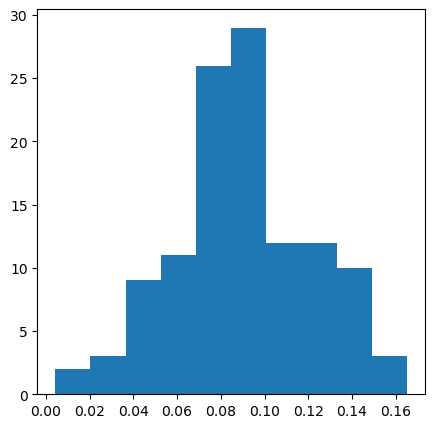

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.hist(result["MGMT_value_x"]);

In [45]:
arr = get_confusion_matrix(result,threshold=0.10)
print(arr)
get_acc_recall(arr)

[[39, 17], [39, 22]]
Acc: 0.5213675213675214 	 Recall: 0.36065573770491804
precision : 0.5641025641025641	 f1-score 0.44000000000000006


In [46]:
arr = get_confusion_matrix(result,threshold=0.08)
print(arr)
get_acc_recall(arr)

[[22, 34], [19, 42]]
Acc: 0.5470085470085471 	 Recall: 0.6885245901639344
precision : 0.5526315789473685	 f1-score 0.6131386861313869


In [47]:
arr = get_confusion_matrix(result,threshold=0.09)
print(arr)
get_acc_recall(arr)

[[30, 26], [37, 24]]
Acc: 0.46153846153846156 	 Recall: 0.39344262295081966
precision : 0.48	 f1-score 0.43243243243243246


In [48]:
arr = get_confusion_matrix(result,threshold=0.085)
print(arr)
get_acc_recall(arr)

[[25, 31], [28, 33]]
Acc: 0.49572649572649574 	 Recall: 0.5409836065573771
precision : 0.515625	 f1-score 0.528
